In [1]:
# Import relevant packages
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from scipy.stats import pearsonr
import os

In [4]:
# Define country of interest
country = "zimbabwe"

# Set working directory
directory = "/s3/scratch/jamie.towner/flood_aa/"
os.chdir(directory)

output_directory = os.path.join(directory, country, "outputs/plots")
os.makedirs(output_directory, exist_ok=True)  # create directory if it does not already exist 

In [8]:
# Define filenames of interest. Feel free to change the gauging station and forecast issue. You need to pick
# dates where forecast issues are available. 
observed_file = "tokwe.csv"              
glofas_file = "tokwe_2014_02_19.nc"                     

# Define file paths to data 
observed_path = os.path.join(directory, country, "data/observations/gauging_stations", observed_file)
glofas_path = os.path.join(directory,country, "data/forecasts/glofas_reforecasts", glofas_file)

# Load the observed data 
observed_df = pd.read_csv(observed_path, parse_dates=["date"])

# Load the forecast data
glofas_df = xr.open_dataset(glofas_path)

# Take mean across ensemble members
glofas_mean = glofas_df['dis24'].mean(dim='number').squeeze()

# Get forecast start date 
forecast_start = pd.to_datetime(glofas_df['time'].values[0])
forecast_times = forecast_start + pd.to_timedelta(glofas_df['step'].values)

# Ensure glofas_mean is 1D with 46 values for each lead time step
glofas_mean_values = glofas_mean.values.flatten()

# Create pandas series for plotting and analysing 
glofas_series = pd.Series(glofas_mean_values, index=forecast_times)

In [6]:
# ---- Clip observed data to forecast window ----
start_date = glofas_series.index[0]
end_date = glofas_series.index[-1]

# Ensure 'date' column in observed_df is datetime
observed_df['date'] = pd.to_datetime(observed_df['date'])

# Clip to 7-day forecast window
obs_df = observed_df[(observed_df['date'] >= start_date) & (observed_df['date'] <= end_date)]

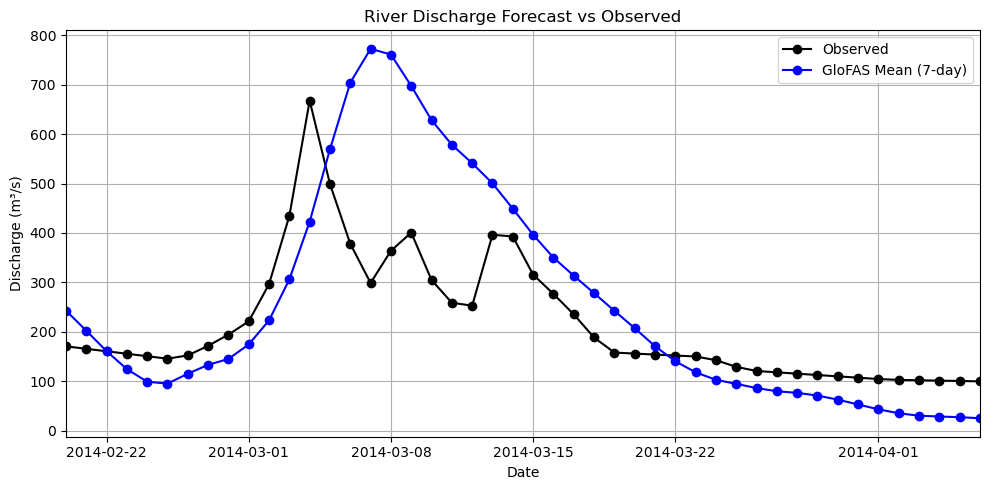

In [7]:
# ---- Plot ----
plt.figure(figsize=(10, 5))

# Plot observed (match to the 7-day forecast window)
start_date = glofas_series.index[0]
end_date = glofas_series.index[-1]
obs_window = observed_df[(observed_df['date'] >= start_date) & (observed_df['date'] <= end_date)]
plt.plot(obs_window['date'], obs_window['discharge'], label='Observed', color='black', marker='o')

# Plot GloFAS mean
plt.plot(glofas_series.index, glofas_series.values, label='GloFAS Mean (7-day)', color='blue', marker='o')

# ---- Styling ----
plt.title("River Discharge Forecast vs Observed")
plt.xlabel("Date")
plt.ylabel("Discharge (m³/s)")
plt.legend()
plt.grid(True)

# Set x-axis limits to match the forecast window
plt.xlim(start_date, end_date)

plt.tight_layout()

plt.savefig(os.path.join(output_directory, "tokwe_2014_02_19.png"), dpi=300)

plt.show()

In [9]:
obs_series = obs_window['discharge'].reset_index(drop=True)
glofas_series_aligned = pd.Series(glofas_series.values, index=range(len(glofas_series)))  # Just in case index types differ

# -- GloFAS verification --
print("\n📈 Verification: GloFAS mean forecasts vs observations")
corr, _ = pearsonr(obs_series, glofas_series)
mae = mean_absolute_error(obs_series, glofas_series)
rmse = root_mean_squared_error(obs_df['discharge'], glofas_series)

bias = np.mean(glofas_series - obs_series)

print(f"Correlation: {corr:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


📈 Verification: GloFAS mean forecasts vs observations
Correlation: 0.77
MAE: 104.05
RMSE: 152.44
